# Embedding Model 만들기

In [3]:
#Dependencies
import pandas as pd
import numpy as np
import itertools

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import matplotlib.pyplot as plt
import plotly.express as px

import time
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

In [4]:
#Loading datasets
ratings_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
movies_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'movies.dat'),encoding='latin-1').readlines()]
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)
users_df = pd.DataFrame(users_list, columns=['UserID','Gender','Age','Occupation','Zip-code'])

f:\pythonproject1\venv\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Could not cast to uint32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# 영화 id를 영화 제목으로
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [6]:
len(movies_list)

3883

In [7]:
movies_df.head(5)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western']

영화와 장르간의 상관관계, 영화와 유저와의 상관관계를 이용해 영화, 장르, 유저의 임배딩을 만들자.

영화-장르의 임배딩을 먼저 학습 후, 학습된 영화 임배딩을 이용해 영화-유저의 임배딩을 학습

利用电影和题材之间的相关关系，电影和用户之间的相关关系，制作电影，题材，玩家的相关关系。
先学习电影-类型的分配，然后利用学习的电影分配学习电影-用户的分配。
电影-题材
电影-用户


## 영화, 장르, 유저 dataframe만들기

In [10]:
# 영화id와 genres dataframe 만들기
movies_genres_df = movies_df[['MovieID', 'Genres']]

In [11]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,Animation|Children's|Comedy
1,2,Adventure|Children's|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama
4,5,Comedy


In [12]:
# 각 영화별 Gneres 분할 후 인덱싱
def _split_and_index(string):
    string = string.split('|')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string

movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))

C:\Users\Asus\AppData\Local\Temp/ipykernel_2420/76332042.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_genres_df['Genres'] = movies_genres_df['Genres'].map(lambda x : _split_and_index(x))


In [13]:
movies_genres_df.head(5)

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [14]:
# 결측값 확인确认缺测值
movies_genres_df.isnull().sum()

MovieID    0
Genres     0
dtype: int64

In [15]:
# 고유값 확인确认固有值
len(movies_genres_df['MovieID'])

3883

In [16]:
movies_genres_df['MovieID'].nunique()

3883

In [17]:
# 유저별 영화 rating dataframe 만들기制作不同用户的电影rating dataframe
user_movie_rating_df = ratings_df[['UserID','MovieID','Rating']]

In [18]:
user_movie_rating_df.head(5)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [19]:
# 결측값 확인：确认缺测值
user_movie_rating_df.isnull().sum()

UserID     0
MovieID    0
Rating     0
dtype: int64

In [20]:
user_movie_rating_df['UserID'].nunique()

6040

In [21]:
user_movie_rating_df['MovieID'].nunique()
len(user_movie_rating_df)

1000209

##  Case1.

## 모델 만들기制作模型

In [22]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

### Movie Genre Embedding 모델

In [23]:
class MovieGenreEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_genres, embedding_size):
        super(MovieGenreEmbedding, self).__init__()
        self.m_g_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        # dot product
        self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        # output
        self.m_g_fc = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.m_g_input(x)
        memb = self.m_embedding(x[0])
        gemb = self.g_embedding(x[1])
        m_g = self.m_g_merge([memb, gemb])
#         m_g = self.reshape(m_g)
        return self.m_g_fc(m_g)

### User Embedding 모델

In [24]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        m_u = self.m_u_merge([x[1], uemb])
        return self.m_u_fc(m_u)

## Data generator 만들기

### Movie Genre batch generator 만들기

In [25]:
# movie genre data generator만들기
movies_genres_df.head()

,MovieID,Genres
0,1,"[2, 3, 4]"
1,2,"[1, 3, 8]"
2,3,"[4, 13]"
3,4,"[4, 7]"
4,5,[4]


In [26]:
movies_genres_dict = {m : g for m, g in zip(movies_genres_df["MovieID"],movies_genres_df["Genres"])}
movies_genres_dict[1]

[2, 3, 4]

In [27]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for movie in movies_genres_df["MovieID"]:
    for i in range(len(genres)):
        if i in movies_genres_dict[movie]:
            positive_m_g_pairs.append((movie, i, 1))
        else:
            negative_m_g_pairs.append((movie, i, 0))

In [28]:
def generate_movie_genre_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):

    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)

    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data

        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data

        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [29]:
# user movie data generator만들기
user_movie_rating_df = user_movie_rating_df.apply(np.int32)
user_movie_rating_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### User batch generator 만들기

In [30]:
modified_user_movie_rating_df = user_movie_rating_df.apply(np.int32)
index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<4].index
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)
u_m_pairs = modified_user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]])

In [31]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}
for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

[1193,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791,
 2018,
 3105,
 2797,
 1270,
 527,
 48,
 1097,
 1721,
 1545,
 2294,
 3186,
 1566,
 588,
 1907,
 783,
 1836,
 1022,
 2762,
 150,
 1,
 1961,
 1962,
 2692,
 260,
 1028,
 1029,
 1207,
 2028,
 531,
 3114,
 608,
 1246]

In [32]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1

    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)

        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)

        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

##  학습学习

In [33]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
MOVIE_BATCH_SIZE = 128
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE

### Movie Genre Embedding 모델 학습

In [34]:
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES, EMBEDDING_SIZE)

In [35]:
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
movie_embedding (Embedding)  multiple                  395300    
_________________________________________________________________
genre_embedding (Embedding)  multiple                  1900      
_________________________________________________________________
movie_genre_dot (Dot)        multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2         
Total params: 397,202
Trainable params: 397,202
Non-trainable params: 0
_________________________________________________________________


In [36]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [37]:
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

In [38]:
# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):

    m_g_generator = generate_movie_genre_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)

    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)

        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}', end='\r')

    m_g_losses.append(m_g_train_loss.result())

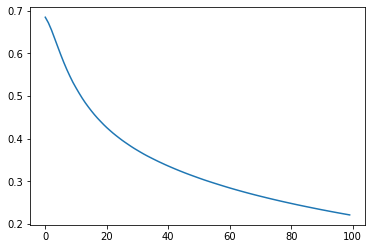

In [39]:
plt.plot(m_g_losses)

In [40]:
m_g_model.save_weights('./save_weights/m_g_model_weights.h5')

### User Movie Embedding 모델 학습

In [41]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [42]:
u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)

In [43]:
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

Model: "user_movie_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
user_embedding (Embedding)   multiple                  604100    
_________________________________________________________________
movie_user_dot (Dot)         multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2         
Total params: 604,102
Trainable params: 604,102
Non-trainable params: 0
_________________________________________________________________


In [44]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [45]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [46]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):

    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)

    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)

        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

poch, Batch size : 128, 19 steps, Loss: 0.5667, Accuracy: 71.41 epoch, Batch size : 128, 40 steps, Loss: 0.5667, Accuracy: 71.41 epoch, Batch size : 128, 59 steps, Loss: 0.5666, Accuracy: 71.41 epoch, Batch size : 128, 80 steps, Loss: 0.5666, Accuracy: 71.41 epoch, Batch size : 128, 99 steps, Loss: 0.5665, Accuracy: 71.41 epoch, Batch size : 128, 118 steps, Loss: 0.5665, Accuracy: 71.41 epoch, Batch size : 128, 138 steps, Loss: 0.5664, Accuracy: 71.41 epoch, Batch size : 128, 158 steps, Loss: 0.5664, Accuracy: 71.41 epoch, Batch size : 128, 178 steps, Loss: 0.5663, Accuracy: 71.41 epoch, Batch size : 128, 197 steps, Loss: 0.5663, Accuracy: 71.41 epoch, Batch size : 128, 217 steps, Loss: 0.5663, Accuracy: 71.41 epoch, Batch size : 128, 237 steps, Loss: 0.5662, Accuracy: 71.41 epoch, Batch size : 128, 257 steps, Loss: 0.5662, Accuracy: 71.41 epoch, Batch size : 128, 277 steps, Loss: 0.5661, Accuracy: 71.41 epoch, Batch size : 128, 297 steps, Loss: 0.5661, Accuracy: 71.41 epoch, Batch siz

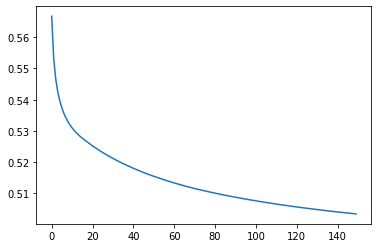

In [47]:
plt.plot(u_m_losses)

In [48]:
u_m_model.save_weights('./save_weights/u_m_model_weights.h5')

### 시각화

In [49]:
# # 모델 가중치 불러오기
# model.load_weights('./save_weights/embedding_24epoch.h5')

In [50]:
# embedded movie dataframe 만들기
embedded_movie = movies_genres_df['MovieID'].apply(m_g_model.get_layer('movie_embedding'))
print(embedded_movie)
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

0       (tf.Tensor(0.051334422, shape=(), dtype=float3...
1       (tf.Tensor(0.057833407, shape=(), dtype=float3...
2       (tf.Tensor(-0.05762411, shape=(), dtype=float3...
3       (tf.Tensor(-0.06605213, shape=(), dtype=float3...
4       (tf.Tensor(-0.024895333, shape=(), dtype=float...
                              ...                        
3878    (tf.Tensor(-0.019941023, shape=(), dtype=float...
3879    (tf.Tensor(-0.11583657, shape=(), dtype=float3...
3880    (tf.Tensor(-0.082596555, shape=(), dtype=float...
3881    (tf.Tensor(-0.10459931, shape=(), dtype=float3...
3882    (tf.Tensor(-0.028373076, shape=(), dtype=float...
Name: MovieID, Length: 3883, dtype: object


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.051334,-0.033301,-0.043116,-0.039382,-0.069120,-0.058435,-0.063152,0.084398,-0.038461,0.008557,...,-0.058165,-0.093481,-0.008613,0.080892,-0.106972,-0.044982,0.041873,-0.028742,-0.040046,0.105397
1,0.057833,-0.040108,-0.077917,-0.069661,-0.010826,0.030789,0.000179,-0.012353,-0.021307,0.018232,...,-0.171234,0.022632,0.044867,-0.043126,-0.152276,0.065182,-0.062169,-0.030675,-0.072194,-0.064947
2,-0.057624,-0.064003,0.008738,0.009629,0.000322,-0.061984,0.094938,-0.022616,-0.108681,0.058600,...,0.021192,0.007214,-0.085793,-0.003427,0.039732,0.074723,0.023312,0.109383,0.058626,0.051254
3,-0.066052,-0.090951,0.078852,0.070617,-0.061381,0.016593,0.040447,-0.040349,-0.099498,0.104244,...,-0.111392,0.006157,-0.077488,0.020586,0.009421,-0.007027,0.132846,0.091958,-0.021682,0.079787
4,-0.024895,-0.036596,0.055280,0.027843,-0.056135,-0.021280,-0.006502,0.001425,-0.052015,0.094585,...,-0.095256,-0.085683,-0.088824,0.075414,-0.059602,0.020846,0.124708,0.032462,-0.011106,0.084762


In [51]:
# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

,0,1,Title,Genres
0,7.134211,-2.288301,Toy Story (1995),Animation|Children's|Comedy
1,1.985635,3.857046,Jumanji (1995),Adventure|Children's|Fantasy
2,4.428862,-3.483137,Grumpier Old Men (1995),Comedy|Romance
3,-0.006107,-7.186000,Waiting to Exhale (1995),Comedy|Drama
4,4.602684,-5.709447,Father of the Bride Part II (1995),Comedy


In [ ]:
# 시각화
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

In [ ]:
# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# embedded user dataframe 만들기
embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
users_df.head()

In [ ]:
# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]
user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

In [ ]:
# 시각화
fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
# 시각화
fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()

##  Case2.

In [ ]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

In [ ]:
class TestUserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, len_movies, embedding_size):
        super(TestUserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        memb = self.m_embedding(x[1])
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [ ]:
test_model = TestUserMovieEmbedding(LEN_USERS, LEN_MOVIES, EMBEDDING_SIZE)

test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [ ]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):

    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_movie_batch(u_m_pairs, batch_size)

    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)

        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}', end='\r')

    test_losses.append(test_train_loss.result())

In [ ]:
# embedded movie dataframe 만들기
embedded_movie = movies_genres_df['MovieID'].apply(test_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

# 시각화
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# embedded user dataframe 만들기
embedded_user = users_df['UserID'].apply(np.int32).apply(test_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Age', hover_data=tsne_df)
fig.show()

In [ ]:
test_model.save_weights('./save_weights/user_movie_at_once.h5')